<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE4-Sensor-Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Loaded subsequences: (3627, 50, 12)
🚀 Creating robust system with 12 sensors
✅ AE model loaded for sensor 0
✅ AE model loaded for sensor 1
✅ AE model loaded for sensor 2
✅ AE model loaded for sensor 3
✅ AE model loaded for sensor 4
✅ AE model loaded for sensor 5
✅ AE model loaded for sensor 6
✅ AE model loaded for sensor 7
✅ AE model loaded for sensor 8
✅ AE model loaded for sensor 9
✅ AE model loaded for sensor 10
✅ AE model loaded for sensor 11
✅ Created system: 12/12 models loaded
▶️ Running streaming test on 20 hold-out subsequences

Step 1/20
System decision: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}
  Sensor 0: anomaly=False drift=False score=0.0013 conf=0.93
  Sensor 1: anomaly=False drift=False score=0.0030 conf=0.83
  Sensor 2: anomaly=False drift=False score=0.0012 conf=0.86
  Sensor 3: anomaly=False drift=False score=0.0001 conf=0.86
  Sensor 4: anomaly=False drift=False scor

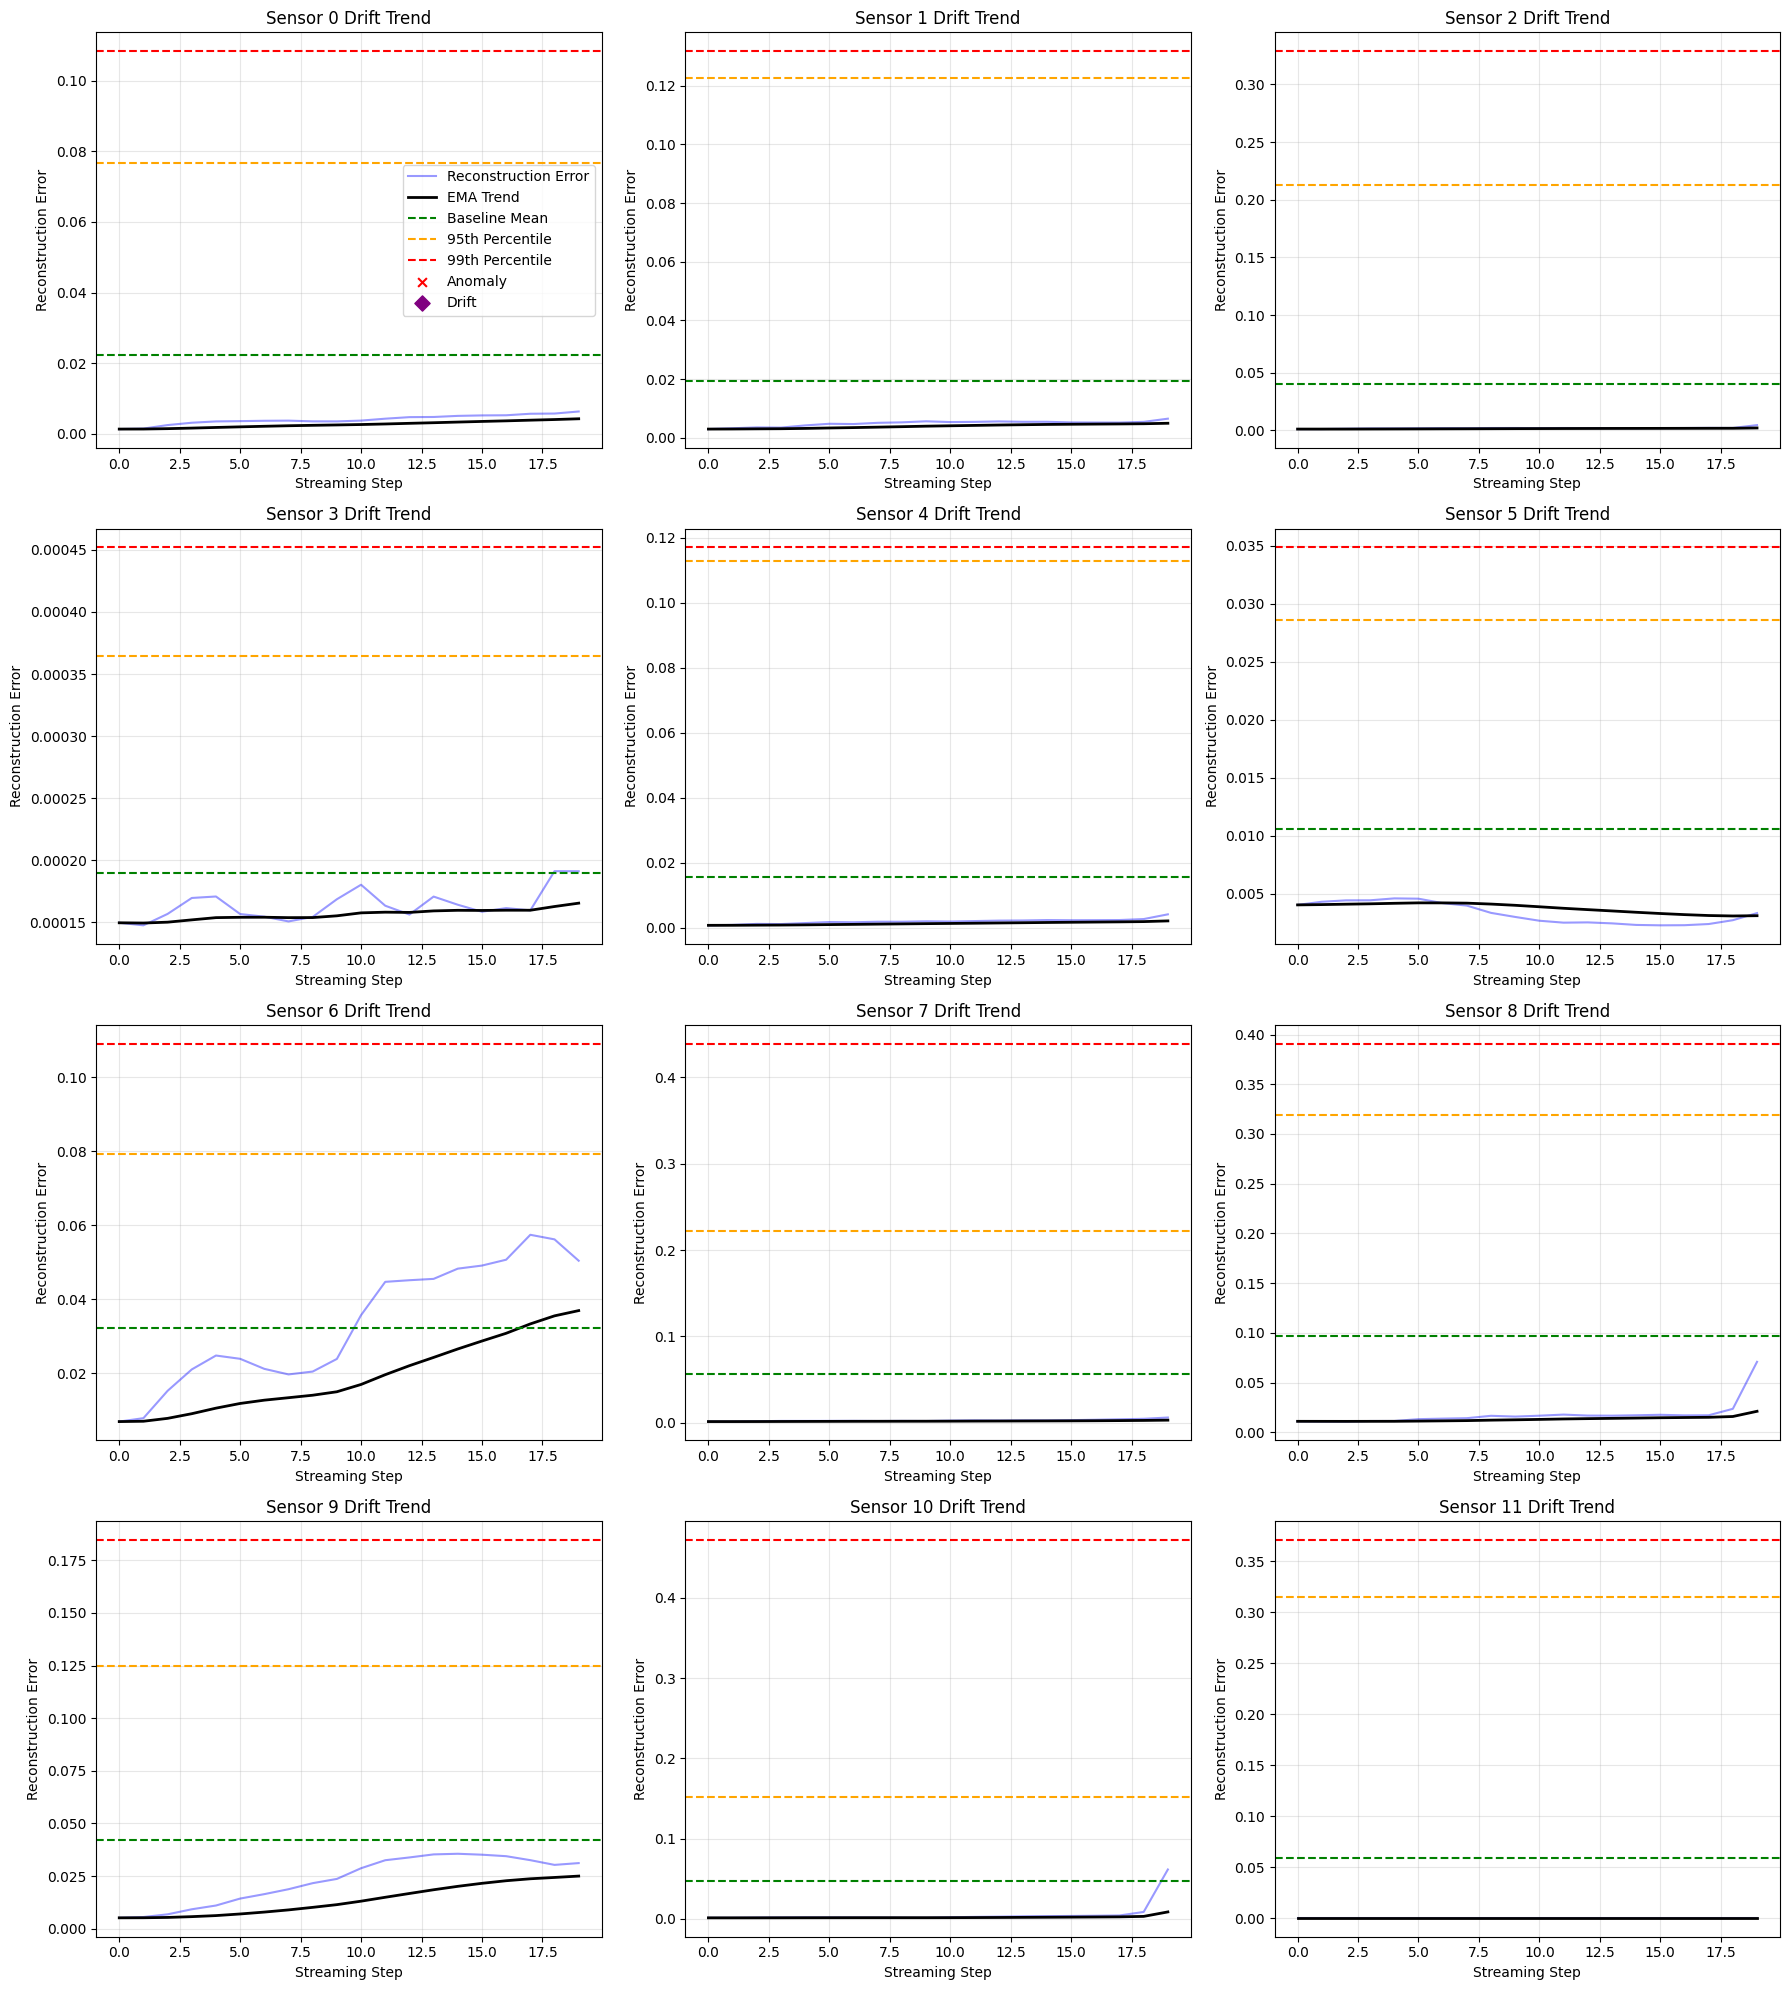

In [5]:
import numpy as np
import pickle
import os
from collections import deque
from datetime import datetime
from typing import Dict, List, Tuple
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.spatial.distance import jensenshannon

# Deep learning
try:
    from tensorflow.keras.models import load_model
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False


# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================

class RobustSensorAgent:
    """
    Robust Sensor Agent for ONE sensor with advanced anomaly & drift detection.

    Loads pretrained AE model + metadata (scaler, baseline errors, rolling stats).
    Computes anomaly score via reconstruction error, applies adaptive thresholding,
    drift detection, and outputs robust anomaly/drift/retrain flags.
    """

    def __init__(self,
                 sensor_id: int,
                 model_path: str = None,
                 window_length: int = 50,
                 memory_size: int = 1000,
                 threshold_k: float = 2.0,
                 drift_threshold: float = 0.1):

        self.sensor_id = sensor_id
        self.window_length = window_length
        self.threshold_k = threshold_k
        self.drift_threshold = drift_threshold

        # Model & metadata
        self.model = None
        self.scaler = None
        self.is_model_loaded = False

        # Buffers
        self.error_memory = deque(maxlen=memory_size)
        self.data_memory = deque(maxlen=memory_size)
        self.recent_errors = deque(maxlen=100)

        # Rolling stats
        self.rolling_stats = {'mean': 0.0, 'std': 1.0, 'q95': 0.0, 'q99': 0.0}
        self.baseline_errors = None

        # Counters
        self.total_processed = 0
        self.anomalies_detected = 0
        self.drift_detected_count = 0
        self.last_stats_update = datetime.now()

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path: str) -> bool:
        """Load pretrained AE model + metadata."""
        try:
            if KERAS_AVAILABLE and model_path.endswith('.h5'):
                self.model = load_model(model_path, compile=False)

                # Correct metadata file
                metadata_path = model_path.replace('_model.h5', '_metadata.pkl')

                if os.path.exists(metadata_path):
                    with open(metadata_path, 'rb') as f:
                        metadata = pickle.load(f)

                    baseline = metadata.get('baseline_stats', None)

                    if baseline is not None:
                        # Initialize rolling stats from training
                        self.rolling_stats['mean'] = baseline['mean']
                        self.rolling_stats['std']  = baseline['std']
                        self.rolling_stats['q95']  = baseline['q95']
                        self.rolling_stats['q99']  = baseline['q99']

                        # Save baseline distribution for drift detection
                        self.baseline_errors = np.array(baseline['baseline_errors'])

                # AE was trained on raw, NOT scaled
                self.scaler = None

            else:
                raise ValueError("Unsupported model format – expecting .h5 AE model")

            self.is_model_loaded = True
            print(f"✅ AE model loaded for sensor {self.sensor_id}")
            return True

        except Exception as e:
            print(f"❌ Failed to load AE model for sensor {self.sensor_id}: {e}")
            return False


    def observe(self, sensor_subsequence: np.ndarray) -> Dict:
        """Observe subsequence [window_length] and return anomaly/drift flags."""
        if not self.is_model_loaded:
            return {"sensor_id": self.sensor_id, "error": "no_model_loaded", "timestamp": datetime.now()}

        if len(sensor_subsequence) != self.window_length:
            return {"sensor_id": self.sensor_id,
                    "error": f"invalid_length_expected_{self.window_length}_got_{len(sensor_subsequence)}",
                    "timestamp": datetime.now()}

        # 1. Anomaly score
        anomaly_score = self._compute_robust_anomaly_score(sensor_subsequence)

        # 2. Update memory
        self.data_memory.append(sensor_subsequence.copy())
        self.error_memory.append(anomaly_score)
        self.recent_errors.append(anomaly_score)

        # 3. Update rolling stats periodically
        if len(self.error_memory) >= 50 and len(self.error_memory) % 10 == 0:
            self._update_rolling_stats(list(self.error_memory)[-50:])

        # 4. Flags
        is_anomaly = self._check_adaptive_anomaly(anomaly_score)
        drift_flag = self._check_advanced_drift()
        needs_retrain = self._check_retrain_need()
        confidence = self._compute_robust_confidence(anomaly_score)

        # 5. Update counters
        self.total_processed += 1
        if is_anomaly: self.anomalies_detected += 1
        if drift_flag: self.drift_detected_count += 1

        return {
            "sensor_id": self.sensor_id,
            "timestamp": datetime.now(),
            "is_anomaly": bool(is_anomaly),
            "drift_flag": bool(drift_flag),
            "needs_retrain_flag": bool(needs_retrain),
            "anomaly_score": float(anomaly_score),
            "confidence": float(confidence),
            "threshold_used": float(self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']),
            "anomaly_rate": self.anomalies_detected / max(1, self.total_processed),
            "drift_rate": self.drift_detected_count / max(1, self.total_processed)
        }

    def _compute_robust_anomaly_score(self, subsequence: np.ndarray) -> float:
        """Compute reconstruction error using AE model on RAW values."""
        try:
            # Ensure shape: [1, window_length, 1]
            X = subsequence.reshape(1, self.window_length, 1)
            reconstruction = self.model.predict(X, verbose=0)

            error = mean_squared_error(
                subsequence.flatten(),
                reconstruction.flatten()
            )
            return max(0.0, error)

        except Exception as e:
            print(f"⚠️ AE inference failed for sensor {self.sensor_id}: {e}")
            # Fallback: variance of raw subsequence
            return float(np.var(subsequence))

    def _update_rolling_stats(self, errors: List[float]):
        errors_array = np.array(errors)
        self.rolling_stats['mean'] = np.mean(errors_array)
        self.rolling_stats['std'] = np.std(errors_array) + 1e-8
        self.rolling_stats['q95'] = np.percentile(errors_array, 95)
        self.rolling_stats['q99'] = np.percentile(errors_array, 99)
        self.last_stats_update = datetime.now()

    def _check_adaptive_anomaly(self, score: float) -> bool:
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        return score > threshold

    def _check_advanced_drift(self) -> bool:
        if self.baseline_errors is None or len(self.recent_errors) < 30:
            return False
        try:
            hist_baseline, bins = np.histogram(self.baseline_errors, bins=20, density=True)
            hist_recent, _ = np.histogram(list(self.recent_errors), bins=bins, density=True)
            hist_baseline += 1e-10; hist_recent += 1e-10
            hist_baseline /= hist_baseline.sum(); hist_recent /= hist_recent.sum()
            js_divergence = jensenshannon(hist_baseline, hist_recent)
            return js_divergence > self.drift_threshold
        except Exception:
            try:
                _, p_value = stats.ks_2samp(self.baseline_errors, list(self.recent_errors))
                return p_value < 0.05
            except:
                return False

    def _check_retrain_need(self) -> bool:
        if len(self.error_memory) < 100: return False
        recent_errors = list(self.error_memory)[-50:]
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        anomaly_rate = sum(1 for e in recent_errors if e > threshold) / len(recent_errors)
        criteria = [
            anomaly_rate > 0.3,
            self.drift_detected_count > 0.1 * self.total_processed,
            np.mean(recent_errors) > 2.0 * self.rolling_stats['mean'] if len(recent_errors) > 0 else False,
            (datetime.now() - self.last_stats_update).days > 7
        ]
        return sum(criteria) >= 2

    def _compute_robust_confidence(self, score: float) -> float:
        if self.rolling_stats['std'] == 0: return 0.5
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        distance_from_threshold = abs(score - threshold) / self.rolling_stats['std']
        return min(1.0, distance_from_threshold / 3.0)


# =====================================================
# ROBUST MASTER AGENT
# =====================================================

class RobustMasterAgent:
    """Aggregates sensor results, makes system-level anomaly/drift/retrain decisions."""
    def __init__(self, sensor_agents: List[RobustSensorAgent],
                 system_anomaly_threshold: float = 0.3,
                 drift_threshold: float = 0.2,
                 retrain_threshold: float = 0.15):
        self.sensor_agents = sensor_agents
        self.num_sensors = len(sensor_agents)
        self.system_anomaly_threshold = system_anomaly_threshold
        self.drift_threshold = drift_threshold
        self.retrain_threshold = retrain_threshold

    def process_system_input(self, system_subsequence: np.ndarray) -> Dict:
        """Process [window_length, num_sensors] multivariate subsequence."""
        timestamp = datetime.now()
        if system_subsequence.shape[1] != self.num_sensors:
            return {"error": f"Expected {self.num_sensors} sensors, got {system_subsequence.shape[1]}",
                    "timestamp": timestamp}

        # 1. Collect sensor observations
        sensor_results = []
        for i, agent in enumerate(self.sensor_agents):
            sensor_data = system_subsequence[:, i]
            result = agent.observe(sensor_data)
            sensor_results.append(result)

        # 2. Simple aggregation
        anomalies = sum(1 for r in sensor_results if r.get("is_anomaly"))
        drifts = sum(1 for r in sensor_results if r.get("drift_flag"))
        retrains = sum(1 for r in sensor_results if r.get("needs_retrain_flag"))

        anomaly_rate = anomalies / max(1, self.num_sensors)
        drift_rate = drifts / max(1, self.num_sensors)
        retrain_rate = retrains / max(1, self.num_sensors)

        system_decisions = {
            "system_anomaly": anomaly_rate >= self.system_anomaly_threshold,
            "system_drift": drift_rate >= self.drift_threshold,
            "system_needs_retrain": retrain_rate >= self.retrain_threshold,
            "anomaly_rate": anomaly_rate,
            "drift_rate": drift_rate,
            "retrain_rate": retrain_rate
        }

        return {
            "timestamp": timestamp,
            "sensor_results": sensor_results,
            "system_decisions": system_decisions
        }


# =====================================================
# SYSTEM CREATION
# =====================================================

def create_robust_system(num_sensors: int, models_dir: str) -> Tuple[List[RobustSensorAgent], RobustMasterAgent]:
    """Create robust sensor system loading AE models + metadata."""
    print(f"🚀 Creating robust system with {num_sensors} sensors")
    sensor_agents = []
    for sensor_id in range(num_sensors):
        model_path = os.path.join(models_dir, f"sensor_{sensor_id}_model.h5")
        agent = RobustSensorAgent(sensor_id=sensor_id,
                                  model_path=model_path if os.path.exists(model_path) else None,
                                  window_length=50,
                                  memory_size=1000,
                                  threshold_k=2.0,
                                  drift_threshold=0.1)
        sensor_agents.append(agent)

    master = RobustMasterAgent(sensor_agents=sensor_agents,
                               system_anomaly_threshold=0.3,
                               drift_threshold=0.2,
                               retrain_threshold=0.15)
    print(f"✅ Created system: {len([a for a in sensor_agents if a.is_model_loaded])}/{num_sensors} models loaded")

    return sensor_agents, master



import matplotlib.pyplot as plt
import numpy as np

def plot_sensor_drift_trends(sensor_logs, metadata_list, window_size=20):
    """
    Plot reconstruction error trend lines for each sensor.

    Args:
        sensor_logs: list of length T, where each element is a dict:
            {
                'sensor_id': int,
                'scores': [score1, score2, ... for each timestep],
                'anomalies': [0/1 flags],
                'drift': [0/1 flags]
            }
        metadata_list: list of sensor metadata:
            baseline_stats['mean'], ['q95'], ['q99']
    """

    num_sensors = len(sensor_logs)
    cols = 3
    rows = int(np.ceil(num_sensors / cols))

    plt.figure(figsize=(18, 5 * rows))

    for sid, log in enumerate(sensor_logs):
        scores = np.array(log['scores'])
        anomalies = np.array(log['anomalies'])
        drift = np.array(log['drift'])

        # Baseline thresholds
        baseline = metadata_list[sid]['mean']
        q95 = metadata_list[sid]['q95']
        q99 = metadata_list[sid]['q99']

        # Smooth trend line: EMA
        ema = pd.Series(scores).ewm(span=window_size, adjust=False).mean()

        ax = plt.subplot(rows, cols, sid + 1)

        # Raw reconstruction error
        ax.plot(scores, color='blue', alpha=0.4, label="Reconstruction Error")

        # EMA trend line
        ax.plot(ema, color='black', linewidth=2, label="EMA Trend")

        # Baseline bands
        ax.axhline(baseline, color='green', linestyle='--', label="Baseline Mean")
        ax.axhline(q95, color='orange', linestyle='--', label="95th Percentile")
        ax.axhline(q99, color='red', linestyle='--', label="99th Percentile")

        # Mark anomalies
        anomaly_points = np.where(anomalies == 1)[0]
        ax.scatter(anomaly_points, scores[anomaly_points], color='red',
                   s=40, marker='x', label="Anomaly" if sid == 0 else "")

        # Mark drifts
        drift_points = np.where(drift == 1)[0]
        ax.scatter(drift_points, scores[drift_points], color='purple',
                   s=60, marker='D', label="Drift" if sid == 0 else "")

        ax.set_title(f"Sensor {sid} Drift Trend")
        ax.set_xlabel("Streaming Step")
        ax.set_ylabel("Reconstruction Error")
        ax.grid(alpha=0.3)

        if sid == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()


# =====================================================
# DEMO ENTRYPOINT
# =====================================================

import numpy as np
if __name__ == "__main__":
    models_dir = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/sensor/model"

    # Load precomputed subsequences
    data_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy"
    subsequences = np.load(data_path)   # shape: [num_samples, window_length, num_sensors]

    print(f"✅ Loaded subsequences: {subsequences.shape}")
    num_samples, window_length, num_sensors = subsequences.shape

    # Take last 1000 samples as hold-out
    holdout = subsequences[-1000:]

    # Create agents + master
    sensor_agents, master = create_robust_system(num_sensors=num_sensors, models_dir=models_dir)

    # --- Initialize logging for each sensor ---
    sensor_logs = []
    for sid in range(num_sensors):
        sensor_logs.append({
            'sensor_id': sid,
            'scores': [],
            'anomalies': [],
            'drift': []
        })

    # Load metadata for drift/baseline bands
    metadata_list = []
    for sid in range(num_sensors):
        meta_path = os.path.join(models_dir, f"sensor_{sid}_metadata.pkl")
        if os.path.exists(meta_path):
            with open(meta_path, 'rb') as f:
                meta = pickle.load(f)
                metadata_list.append(meta['baseline_stats'])
        else:
            metadata_list.append({'mean':0,'q95':0,'q99':0})

    # Streaming test: pick 10–100 samples
    test_samples = 20  # you can set 10, 20, 100, etc.

    print(f"▶️ Running streaming test on {test_samples} hold-out subsequences")

    for i in range(test_samples):
        live_seq = holdout[i]   # shape [window_length, num_sensors]

        result = master.process_system_input(live_seq)

        # Print system-level decision
        print(f"\nStep {i+1}/{test_samples}")
        print("System decision:", result["system_decisions"])

        # Print sensor-level results
        for r in result["sensor_results"]:
            print(f"  Sensor {r['sensor_id']}: "
                  f"anomaly={r['is_anomaly']} "
                  f"drift={r['drift_flag']} "
                  f"score={r['anomaly_score']:.4f} "
                  f"conf={r['confidence']:.2f}")
            sid = r['sensor_id']
            sensor_logs[sid]['scores'].append(r['anomaly_score'])
            sensor_logs[sid]['anomalies'].append(1 if r['is_anomaly'] else 0)
            sensor_logs[sid]['drift'].append(1 if r['drift_flag'] else 0)


    print("\n📈 Generating Sensor Drift Trend Plots...")
    plot_sensor_drift_trends(sensor_logs, metadata_list, window_size=20)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')